In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Extracting data and sample period

In [65]:
us_ticker = "^GSPC"
india_ticker = "^BSESN"

In [66]:
start_date = "1999-01-01"
end_date = "2024-01-01"

In [67]:
us_data = yf.download(us_ticker,start=start_date, end=end_date)
india_data = yf.download(india_ticker,start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [68]:
#Selecting only the close prices for simplicity
us_data = us_data[['Close']].rename(columns={'Close': 'US_Close'})
india_data = india_data[['Close']].rename(columns={'Close': 'India_Close'})

### Data Cleaning and Merging

In [69]:
#merging data
merged_data = pd.merge(us_data, india_data, left_index=True, right_index=True, how='inner')
merged_data

,US_Close,India_Close
Date,,
1999-01-04,1228.099976,3122.040039
1999-01-05,1244.780029,3149.060059
1999-01-06,1272.339966,3205.679932
1999-01-07,1269.729980,3299.090088
1999-01-08,1275.089966,3397.840088
...,...,...
2023-12-22,4754.629883,71106.960938
2023-12-26,4774.750000,71336.796875
2023-12-27,4781.580078,72038.429688


In [70]:
merged_data.dropna(inplace=True)
merged_data.head()

,US_Close,India_Close
Date,,
1999-01-04,1228.099976,3122.040039
1999-01-05,1244.780029,3149.060059
1999-01-06,1272.339966,3205.679932
1999-01-07,1269.729980,3299.090088
1999-01-08,1275.089966,3397.840088


### Correlation Analysis

In [71]:
overall_correl = merged_data['US_Close'].corr(merged_data['India_Close'])
overall_correl

0.9574403815478882

In [72]:
#Rolling Correlation 30 Days
merged_data['Rolling_Correlation'] = merged_data['US_Close'].rolling(window=30).corr(merged_data['India_Close'])

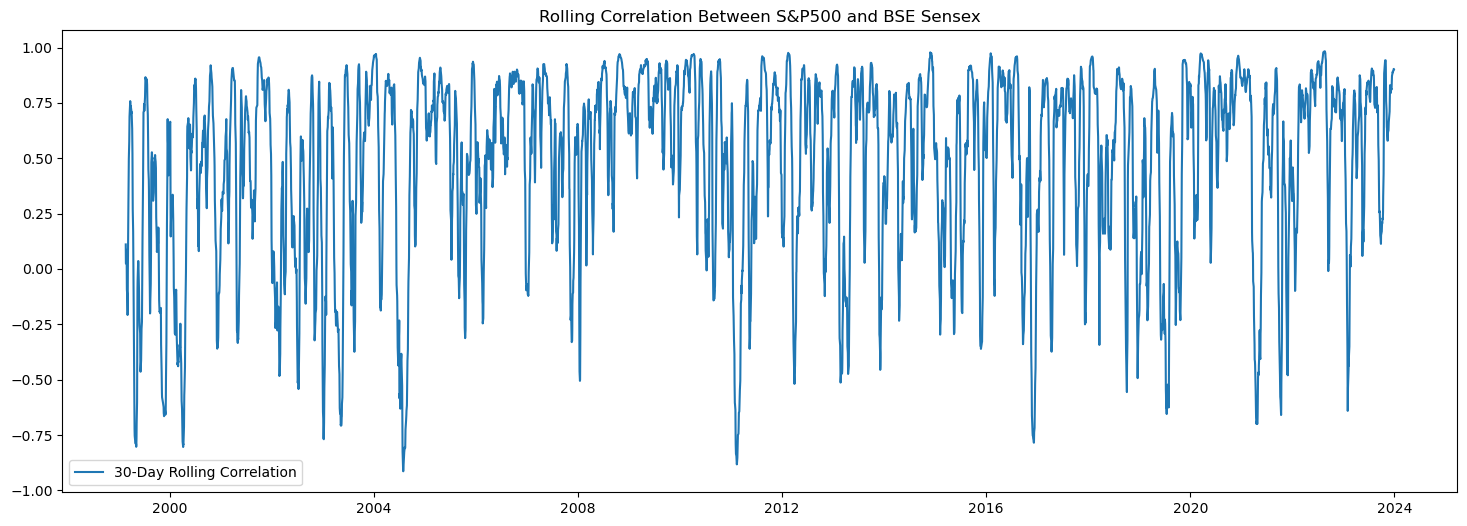

In [73]:
#Plotting Correlations
plt.figure(figsize = (18,6))
plt.plot(merged_data['Rolling_Correlation'], label="30-Day Rolling Correlation")
plt.title("Rolling Correlation Between S&P500 and BSE Sensex")
plt.legend()
plt.show()

### Time Lag Analysis (Cross Correlation)

In [74]:
lagged_correl = {}

for lag in range(-5,6):  # Test lags in the range of -5 to +5 days : Adjustable
    shifted_us = merged_data['US_Close'].shift(lag)
    
    lagged_correl[lag] = shifted_us.corr(merged_data['India_Close'])

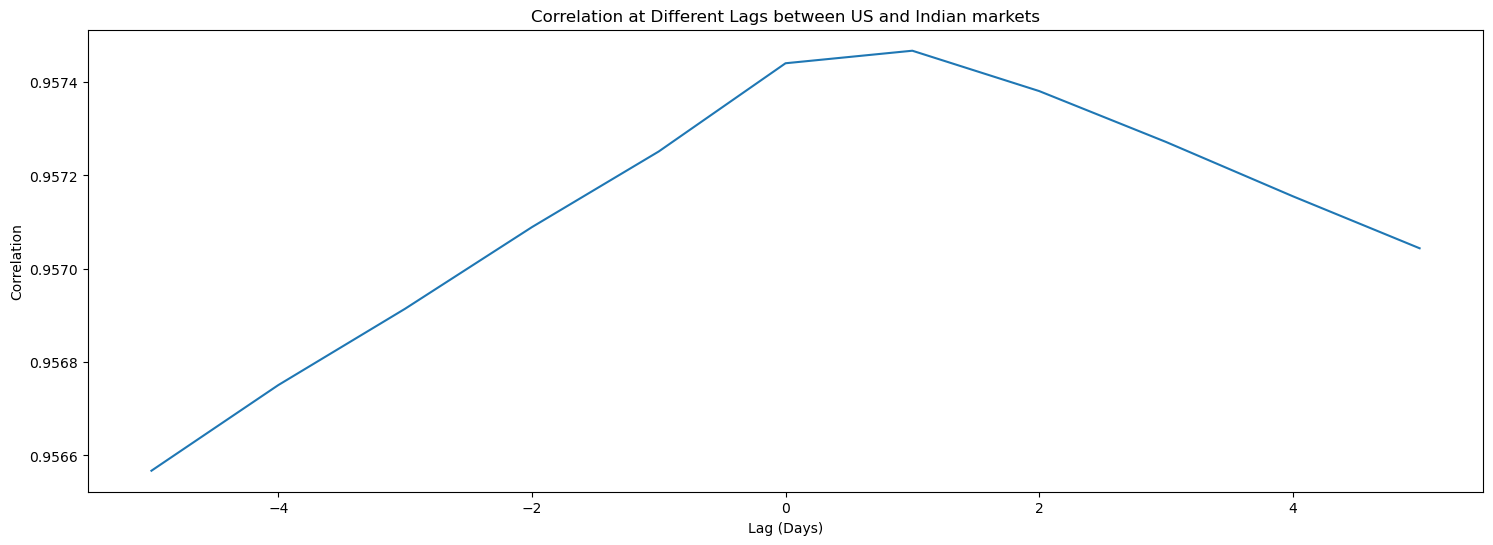

In [75]:
lagged_correl_series = pd.Series(lagged_correl)
plt.figure(figsize=(18,6))
lagged_correl_series.plot()
plt.title("Correlation at Different Lags between US and Indian markets")
plt.xlabel("Lag (Days)")
plt.ylabel("Correlation")
plt.show()

### Conclusion

1. The lagged correlation plot shows a peak correlation around a lag of 0 to +1 days, which implies that the two markets tend to move in sync or with minimal delay.
2. The plot’s shape indicates that while there is a slight increase in correlation at +1 day, the difference isn’t substantial. This suggests that there may not be a strong or reliable arbitrage opportunity due to time lag.
3. If a strong lag effect were present, we’d expect a sharp peak at a specific lag value with noticeably lower correlations at other lags.

This means that the Indian Markets react almost promptly with the changes in the US markets, leaving no room for potential arbitrage opportunities

## Part 2: Simple Predictive Model

In [76]:
import statsmodels.api as sm

In [77]:
merged_data['SP500_Lagged_Return'] = (merged_data['US_Close'].pct_change()).shift(1)
merged_data.dropna(inplace = True)
merged_data['Sensex_Lagged_Return'] = (merged_data['India_Close'].pct_change()).shift(1)
merged_data.dropna(inplace = True)

In [78]:
X = merged_data['SP500_Lagged_Return']
y = merged_data['Sensex_Lagged_Return']

In [79]:
X = sm.add_constant(X) #intercept

In [81]:
model = sm.OLS(y,X)
results = model.fit()

In [82]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Sensex_Lagged_Return   R-squared:                       0.062
Model:                              OLS   Adj. R-squared:                  0.062
Method:                   Least Squares   F-statistic:                     397.2
Date:                  Sun, 03 Nov 2024   Prob (F-statistic):           1.30e-85
Time:                          23:55:07   Log-Likelihood:                 16902.
No. Observations:                  5961   AIC:                        -3.380e+04
Df Residuals:                      5959   BIC:                        -3.379e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0005      0.000      2.903      0.004       0.000       0.001
SP500_Lagged_Return     0.2932      0.015     19.930      0.000       0.264       0.322
==============================================================================
Omnibus:                     1100.464   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25964.089
Skew:                          -0.206   Prob(JB):                         0.00
Kurtosis:                      13.216   Cond. No.                         80.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
y_pred = results.predict(X)

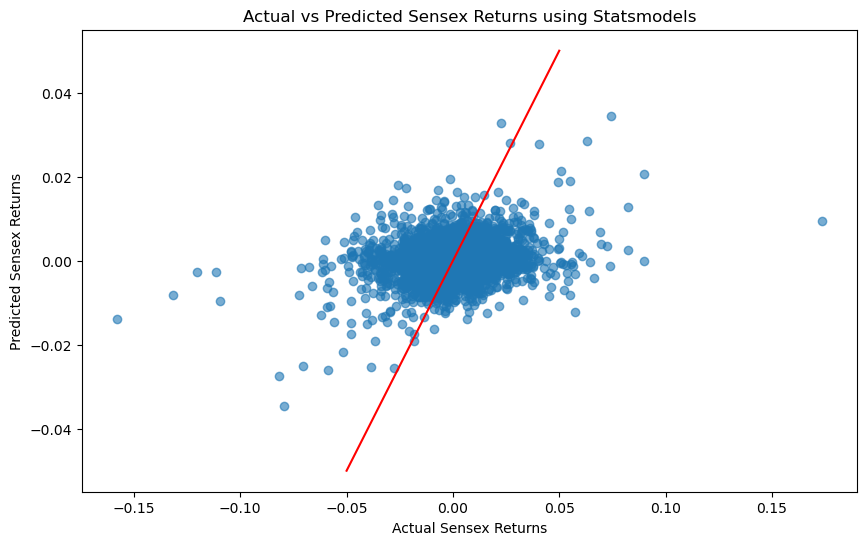

In [88]:
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.6)
plt.plot([-0.05, 0.05], [-0.05, 0.05], color='red')  # reference line
plt.xlabel("Actual Sensex Returns")
plt.ylabel("Predicted Sensex Returns")
plt.title("Actual vs Predicted Sensex Returns using Statsmodels")
plt.show()